In [1]:
import numpy as np
from hiive.mdptoolbox import mdp
import matplotlib.pyplot as plt
import matplotlib

### Define Problem

In [2]:
# The number of population abundance classes
POPULATION_CLASSES = 7
# The number of years since a fire classes
FIRE_CLASSES = 13
# The number of states
STATES = POPULATION_CLASSES * FIRE_CLASSES
# The number of actions
ACTIONS = 2
ACTION_NOTHING = 0
ACTION_BURN = 1

In [3]:
def check_action(x):
    """Check that the action is in the valid range."""
    if not (0 <= x < ACTIONS):
        msg = "Invalid action '%s', it should be in {0, 1}." % str(x)
        raise ValueError(msg)

def check_population_class(x):
    """Check that the population abundance class is in the valid range."""
    if not (0 <= x < POPULATION_CLASSES):
        msg = "Invalid population class '%s', it should be in {0, 1, …, %d}." \
              % (str(x), POPULATION_CLASSES - 1)
        raise ValueError(msg)

def check_fire_class(x):
    """Check that the time in years since last fire is in the valid range."""
    if not (0 <= x < FIRE_CLASSES):
        msg = "Invalid fire class '%s', it should be in {0, 1, …, %d}." % \
              (str(x), FIRE_CLASSES - 1)
        raise ValueError(msg)

def check_probability(x, name="probability"):
    """Check that a probability is between 0 and 1."""
    if not (0 <= x <= 1):
        msg = "Invalid %s '%s', it must be in [0, 1]." % (name, str(x))
        raise ValueError(msg)

In [4]:
def get_habitat_suitability(years):
    """The habitat suitability of a patch relatve to the time since last fire.

    The habitat quality is low immediately after a fire, rises rapidly until
    five years after a fire, and declines once the habitat is mature. See
    Figure 2 in Possingham and Tuck (1997) for more details.

    Parameters
    ----------
    years : int
        The time in years since last fire.

    Returns
    -------
    r : float
        The habitat suitability.

    """
    if years < 0:
        msg = "Invalid years '%s', it should be positive." % str(years)
        raise ValueError(msg)
    if years <= 5:
        return 0.2*years
    elif 5 <= years <= 10:
        return -0.1*years + 1.5
    else:
        return 0.5
    
def convert_state_to_index(population, fire):
    """Convert state parameters to transition probability matrix index.

    Parameters
    ----------
    population : int
        The population abundance class of the threatened species.
    fire : int
        The time in years since last fire.

    Returns
    -------
    index : int
        The index into the transition probability matrix that corresponds to
        the state parameters.

    """
    check_population_class(population)
    check_fire_class(fire)
    return population*FIRE_CLASSES + fire

def convert_index_to_state(index):
    """Convert transition probability matrix index to state parameters.

    Parameters
    ----------
    index : int
        The index into the transition probability matrix that corresponds to
        the state parameters.

    Returns
    -------
    population, fire : tuple of int
        ``population``, the population abundance class of the threatened
        species. ``fire``, the time in years since last fire.

    """
    if not (0 <= index < STATES):
        msg = "Invalid index '%s', it should be in {0, 1, …, %d}." % \
              (str(index), STATES - 1)
        raise ValueError(msg)
    population = index // FIRE_CLASSES
    fire = index % FIRE_CLASSES
    return (population, fire)

def transition_fire_state(F, a):
    """Transition the years since last fire based on the action taken.

    Parameters
    ----------
    F : int
        The time in years since last fire.
    a : int
        The action undertaken.

    Returns
    -------
    F : int
        The time in years since last fire.

    """
    ## Efect of action on time in years since fire.
    if a == ACTION_NOTHING:
        # Increase the time since the patch has been burned by one year.
        # The years since fire in patch is absorbed into the last class
        if F < FIRE_CLASSES - 1:
            F += 1
    elif a == ACTION_BURN:
        # When the patch is burned set the years since fire to 0.
        F = 0

    return F

In [5]:
def get_transition_probabilities(s, x, F, a):
    """Calculate the transition probabilities for the given state and action.

    Parameters
    ----------
    s : float
        The class-independent probability of the population staying in its
        current population abundance class.
    x : int
        The population abundance class of the threatened species.
    F : int
        The time in years since last fire.
    a : int
        The action undertaken.

    Returns
    -------
    prob : array
        The transition probabilities as a vector from state (``x``, ``F``) to
        every other state given that action ``a`` is taken.

    """
    # Check that input is in range
    check_probability(s)
    check_population_class(x)
    check_fire_class(F)
    check_action(a)

    # a vector to store the transition probabilities
    prob = np.zeros(STATES)

    # the habitat suitability value
    r = get_habitat_suitability(F)
    F = transition_fire_state(F, a)

    ## Population transitions
    if x == 0:
        # population abundance class stays at 0 (extinct)
        new_state = convert_state_to_index(0, F)
        prob[new_state] = 1
    elif x == POPULATION_CLASSES - 1:
        # Population abundance class either stays at maximum or transitions
        # down
        transition_same = x
        transition_down = x - 1
        # If action 1 is taken, then the patch is burned so the population
        # abundance moves down a class.
        if a == ACTION_BURN:
            transition_same -= 1
            transition_down -= 1
        # transition probability that abundance stays the same
        new_state = convert_state_to_index(transition_same, F)
        prob[new_state] = 1 - (1 - s)*(1 - r)
        # transition probability that abundance goes down
        new_state = convert_state_to_index(transition_down, F)
        prob[new_state] = (1 - s)*(1 - r)
    else:
        # Population abundance class can stay the same, transition up, or
        # transition down.
        transition_same = x
        transition_up = x + 1
        transition_down = x - 1
        # If action 1 is taken, then the patch is burned so the population
        # abundance moves down a class.
        if a == ACTION_BURN:
            transition_same -= 1
            transition_up -= 1
            # Ensure that the abundance class doesn't go to -1
            if transition_down > 0:
                transition_down -= 1
        # transition probability that abundance stays the same
        new_state = convert_state_to_index(transition_same, F)
        prob[new_state] = s
        # transition probability that abundance goes up
        new_state = convert_state_to_index(transition_up, F)
        prob[new_state] = (1 - s)*r
        # transition probability that abundance goes down
        new_state = convert_state_to_index(transition_down, F)
        # In the case when transition_down = 0 before the effect of an action
        # is applied, then the final state is going to be the same as that for
        # transition_same, so we need to add the probabilities together.
        prob[new_state] += (1 - s)*(1 - r)

    # Make sure that the probabilities sum to one
    assert (prob.sum() - 1) < np.spacing(1)
    return prob

In [6]:
def get_transition_and_reward_arrays(s):
    """Generate the fire management transition and reward matrices.

    The output arrays from this function are valid input to the mdptoolbox.mdp
    classes.

    Let ``S`` = number of states, and ``A`` = number of actions.

    Parameters
    ----------
    s : float
        The class-independent probability of the population staying in its
        current population abundance class.

    Returns
    -------
    out : tuple
        ``out[0]`` contains the transition probability matrices P and
        ``out[1]`` contains the reward vector R. P is an  ``A`` × ``S`` × ``S``
        numpy array and R is a numpy vector of length ``S``.

    """
    check_probability(s)

    # The transition probability array
    transition = np.zeros((ACTIONS, STATES, STATES))
    # The reward vector
    reward = np.zeros(STATES)
    # Loop over all states
    for idx in range(STATES):
        # Get the state index as inputs to our functions
        x, F = convert_index_to_state(idx)
        # The reward for being in this state is 1 if the population is extant
        if x != 0:
            reward[idx] = 1
        # Loop over all actions
        for a in range(ACTIONS):
            # Assign the transition probabilities for this state, action pair
            transition[a][idx] = get_transition_probabilities(s, x, F, a)

    return (transition, reward)

### MDP Solvers (VI, PI, QL, and FH)

In [7]:
def solve_mdp_vi(P, R, gamma=0.96, epsilon=0.01, max_iter=1000, verbose=False):
    """Solve the problem as a finite horizon Markov decision process.

    The optimal policy at each stage is found using backwards induction.
    Possingham and Tuck report strategies for a 50 year time horizon, so the
    number of stages for the finite horizon algorithm is set to 50. There is no
    discount factor reported, so we set it to 0.96 rather arbitrarily.

    Returns
    -------
    sdp : mdptoolbox.mdp.FiniteHorizon
        The PyMDPtoolbox object that represents a finite horizon MDP. The
        optimal policy for each stage is accessed with mdp.policy, which is a
        numpy array with 50 columns (one for each stage).

    """
    vi = mdp.ValueIteration(transitions=P, 
                            reward=R, 
                            gamma=gamma, 
                            epsilon=epsilon, 
                            max_iter=max_iter)
    if verbose:
        vi.setVerbose()
        
    vi.run()
    
    return vi

In [8]:
def solve_mdp_pi(P, R, gamma=0.96, max_iter=1000, verbose=False):
    """Solve the problem as a finite horizon Markov decision process.

    The optimal policy at each stage is found using backwards induction.
    Possingham and Tuck report strategies for a 50 year time horizon, so the
    number of stages for the finite horizon algorithm is set to 50. There is no
    discount factor reported, so we set it to 0.96 rather arbitrarily.

    Returns
    -------
    pi : mdptoolbox.mdp.PolicyIteration

    """
    pi = mdp.PolicyIteration(transitions=P, 
                             reward=R, 
                             gamma=gamma, 
                             max_iter=max_iter)
    if verbose:
        pi.setVerbose()
        
    pi.run()
    
    return pi

In [9]:
def solve_mdp_ql(P, R, gamma=0.96, 
                 alpha=1.0, alpha_decay=0.9999, alpha_min=0.001,
                 epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.999, 
                 n_iter=10000, verbose=False):
    """Solve the problem as a finite horizon Markov decision process.

    The optimal policy at each stage is found using backwards induction.
    Possingham and Tuck report strategies for a 50 year time horizon, so the
    number of stages for the finite horizon algorithm is set to 50. There is no
    discount factor reported, so we set it to 0.96 rather arbitrarily.

    Returns
    -------
    ql : mdptoolbox.mdp.QLearning

    """
    ql = mdp.QLearning(transitions=P, 
                       reward=R, 
                       gamma=gamma,
                       alpha=alpha, 
                       alpha_decay=alpha_decay, 
                       alpha_min=alpha_min,
                       epsilon_min=epsilon_min, 
                       epsilon_decay=epsilon_decay,
                       n_iter=n_iter)
    if verbose:
        ql.setVerbose()
        
    ql.run()
    
    return ql

In [10]:
def solve_mdp_fh(P, R, gamma=0.96, N=50, verbose=False):
    """Solve the problem as a finite horizon Markov decision process.

    The optimal policy at each stage is found using backwards induction.
    Possingham and Tuck report strategies for a 50 year time horizon, so the
    number of stages for the finite horizon algorithm is set to 50. There is no
    discount factor reported, so we set it to 0.96 rather arbitrarily.

    Returns
    -------
    ql : mdptoolbox.mdp.QLearning

    """
    ql = mdp.FiniteHorizon(transitions=P, 
                           reward=R, 
                           gamma=gamma, 
                           N=N)
    if verbose:
        fh.setVerbose()
        
    ql.run()
    
    return ql

### Plotting Functions

In [11]:
def print_policy(policy):
    """Print out a policy vector as a table to console

    Let ``S`` = number of states.

    The output is a table that has the population class as rows, and the years
    since a fire as the columns. The items in the table are the optimal action
    for that population class and years since fire combination.

    Parameters
    ----------
    p : array
        ``p`` is a numpy array of length ``S``.

    """
    p = np.array(policy).reshape(POPULATION_CLASSES, FIRE_CLASSES)
    print("    " + " ".join("%2d" % f for f in range(FIRE_CLASSES)))
    print("    " + "---" * FIRE_CLASSES)
    for x in range(POPULATION_CLASSES):
        print(" %2d|" % x + " ".join("%2d" % p[x, f] for f in
                                     range(FIRE_CLASSES)))

In [23]:
def heatmap(data, title, ax=None, cbar_kw={}, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    plt.title(title)
    
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xlabel('Years since last fire')
    ax.set_ylabel('Population abundance classes')

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_heatmap(value_list, policy_list, increment, title, save_as=None):
    index = 1
    last = 0
    for value_array, policy_array in zip(value_list[::increment]+[value_list[-1]], 
                                         policy_list[::increment]+[policy_list[-1]]):
        fig, ax = plt.subplots(figsize=(7, 7))
        im = heatmap(value_array.reshape(POPULATION_CLASSES, FIRE_CLASSES), title=(title+': step %d') % (index),
                           cmap="gray")
        texts = annotate_heatmap(im, valfmt="{x:.2f}")
        fig.tight_layout()
        if save_as != None:
            plt.savefig('./figures/13x7 (Forest Fire Management)/' + save_as + ' Step %d.png' %(index), dpi=300)
        plt.show()
        if last > 0:
            break
        if index+increment >= len(value_list):
            index = len(value_list)
            last += 1
        else:
            index += increment

In [13]:
def plot_times(times_list, title=None, xlabel='# of Iterations', ylabel='Time (s)', 
               save_as=None):
    plt.plot(range(1, len(times_list)+1), times_list, 
             marker='o', color='orange', linestyle=':', markersize=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [14]:
def plot_max_values(max_values_list, title=None, xlabel='# of Iterations', ylabel='Max Value',
                 save_as=None):
    plt.plot(range(1, len(max_values_list)+1), max_values_list, 
             marker='o', color='blue', linestyle=':', markersize=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

### Transition and Reward Matrices

In [15]:
P, R = get_transition_and_reward_arrays(0.25)

### Finite Horizon (FH)

In [16]:
%%time
# Original solution
fh = solve_mdp_fh(P, R, gamma=0.96, N=50, verbose=False)
print_policy(fh.policy[:, 0])

     0  1  2  3  4  5  6  7  8  9 10 11 12
    ---------------------------------------
  0| 0  0  0  0  0  0  0  0  0  0  0  0  0
  1| 0  0  0  0  0  0  0  0  0  0  0  0  0
  2| 0  0  0  0  0  0  0  0  0  0  0  0  0
  3| 0  0  0  0  0  0  0  0  0  0  0  0  0
  4| 0  0  0  0  0  0  0  0  0  0  0  0  0
  5| 0  0  0  0  0  0  0  0  0  0  0  0  0
  6| 0  0  0  0  0  0  1  1  1  1  1  1  1
Wall time: 12.5 ms


### Value Iteration (VI)

In [17]:
%%time
np.random.seed(0)
vi = solve_mdp_vi(P, R, gamma=0.96, epsilon=0.01, max_iter=1000, verbose=False)
print_policy(vi.policy)

     0  1  2  3  4  5  6  7  8  9 10 11 12
    ---------------------------------------
  0| 0  0  0  0  0  0  0  0  0  0  0  0  0
  1| 0  0  0  0  0  0  0  0  0  0  0  0  0
  2| 0  0  0  0  0  0  0  0  0  0  0  0  0
  3| 0  0  0  0  0  0  0  0  0  0  0  0  0
  4| 0  0  0  0  0  0  0  0  0  0  0  0  0
  5| 0  0  0  0  0  0  0  0  0  0  0  0  0
  6| 0  0  0  0  0  0  1  1  1  1  1  1  1
Wall time: 16.9 ms


In [18]:
times_list_vi = []
max_values_list_vi = []
value_list_vi = []
policy_list_vi = []

for stats in vi.run_stats:
    times_list_vi.append(stats['Time'])
    max_values_list_vi.append(stats['Max V'])
    value_list_vi.append(stats['Value'])
    policy_list_vi.append(stats['Policy'])

In [19]:
print('# of iterations to convergence: %d' % len(policy_list_vi))

# of iterations to convergence: 151


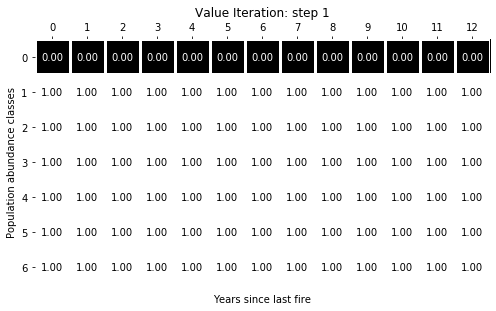

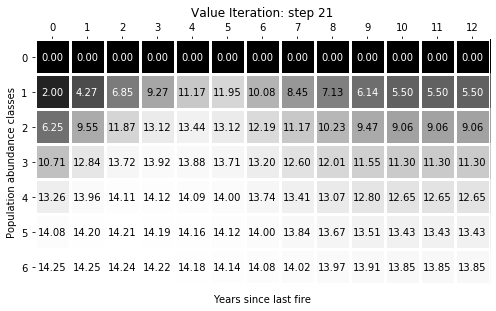

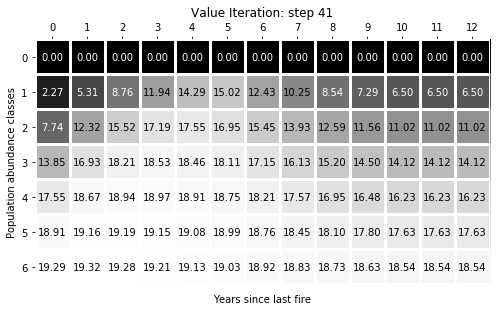

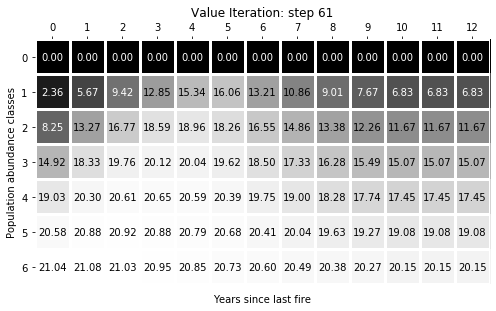

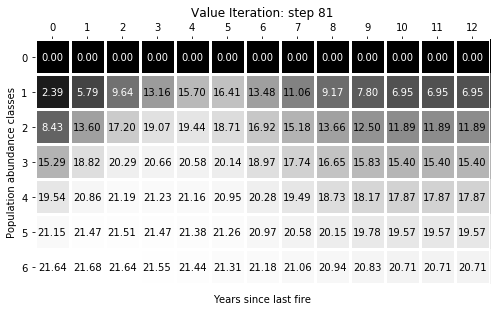

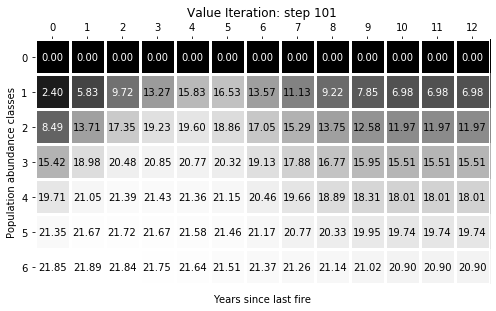

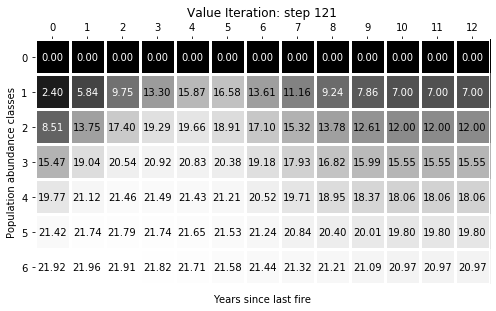

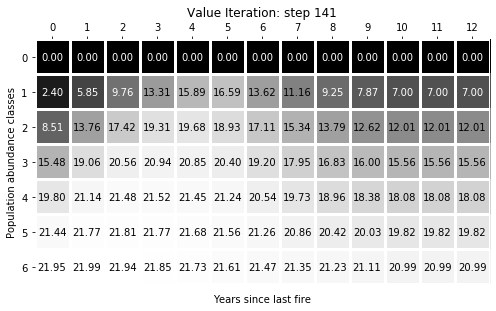

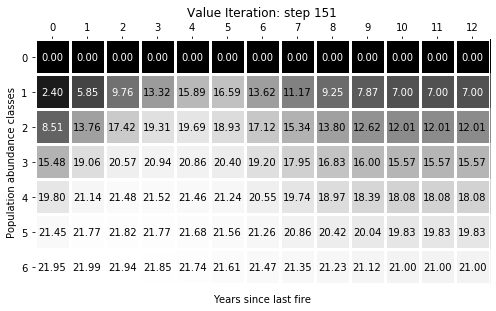

In [24]:
plot_heatmap(value_list_vi, policy_list_vi, increment=20, title='Value Iteration', save_as='VI/Value Iteration')

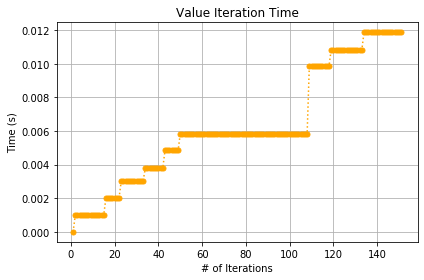

In [25]:
plot_times(times_list_vi, title='Value Iteration Time', save_as='VI/7x13_time')

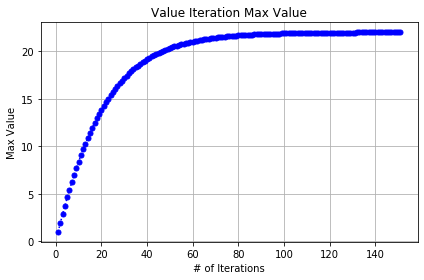

In [26]:
plot_max_values(max_values_list_vi, title='Value Iteration Max Value', save_as='VI/7x13_max_val')

### Policy Iteration (PI)

In [27]:
%%time
np.random.seed(0)
pi = solve_mdp_pi(P, R, gamma=0.96, max_iter=1000, verbose=False)
print_policy(pi.policy)

     0  1  2  3  4  5  6  7  8  9 10 11 12
    ---------------------------------------
  0| 1  1  1  1  1  1  1  1  1  1  1  1  1
  1| 0  0  0  0  0  0  0  0  0  0  0  0  0
  2| 0  0  0  0  0  0  0  0  0  0  0  0  0
  3| 0  0  0  0  0  0  0  0  0  0  0  0  0
  4| 0  0  0  0  0  0  0  0  0  0  0  0  0
  5| 0  0  0  0  0  0  0  0  0  0  0  0  0
  6| 0  0  0  0  0  0  1  1  1  1  1  1  1
Wall time: 27.6 ms


In [28]:
times_list_pi = []
max_values_list_pi = []
value_list_pi = []
policy_list_pi = []

for stats in pi.run_stats:
    times_list_pi.append(stats['Time'])
    max_values_list_pi.append(stats['Max V'])
    value_list_pi.append(stats['Value'])
    policy_list_pi.append(stats['Policy'])

In [29]:
print('# of iterations to convergence: %d' % len(policy_list_pi))

# of iterations to convergence: 3


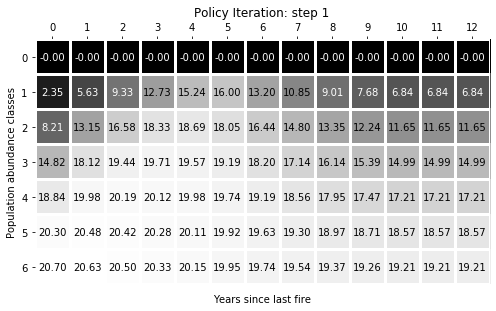

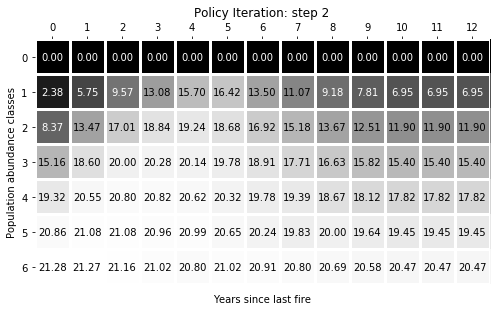

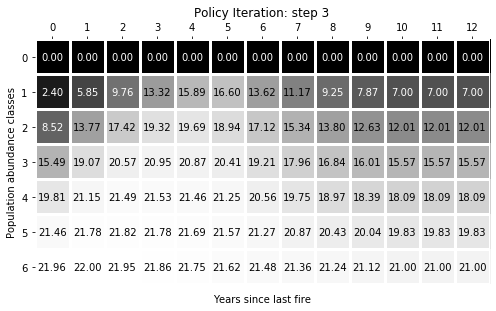

In [30]:
plot_heatmap(value_list_pi, policy_list_pi, increment=1, title='Policy Iteration', save_as='PI/Policy Iteration')

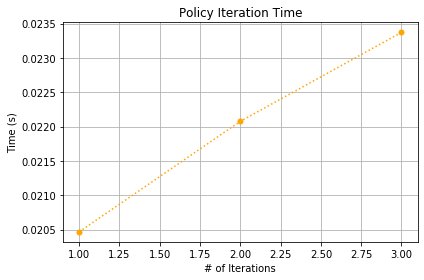

In [31]:
plot_times(times_list_pi, title='Policy Iteration Time', save_as='PI/7x13_time')

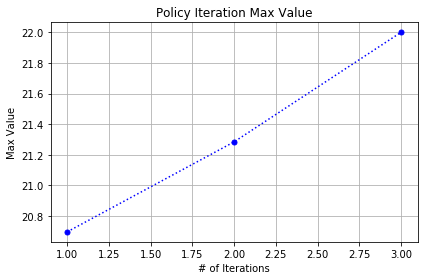

In [32]:
plot_max_values(max_values_list_pi, title='Policy Iteration Max Value', save_as='PI/7x13_max_val')

### Q-Learning (QL)

In [33]:
%%time
np.random.seed(0)
n_iter = 500000
ql = solve_mdp_ql(P, R, gamma=0.96, 
                  alpha=1.0, alpha_decay=(n_iter-1)/n_iter, alpha_min=0.001,
                  epsilon=1.0, epsilon_min=0.1, epsilon_decay=(n_iter-1)/n_iter,
                  n_iter=n_iter, verbose=False)
print_policy(ql.policy)

     0  1  2  3  4  5  6  7  8  9 10 11 12
    ---------------------------------------
  0| 0  0  0  0  0  0  0  0  0  0  0  0  0
  1| 0  0  0  0  0  0  0  0  0  0  0  0  0
  2| 0  0  0  0  0  0  0  0  0  0  0  0  0
  3| 0  0  0  0  0  0  0  0  0  0  0  0  0
  4| 0  0  0  0  0  0  0  0  0  0  0  0  0
  5| 0  0  0  0  0  0  0  0  0  0  0  0  1
  6| 0  0  0  0  0  0  0  0  0  1  1  1  1
Wall time: 35.4 s


In [34]:
times_list_ql = []
max_values_list_ql = []
value_list_ql = []
policy_list_ql = []

for stats in ql.run_stats:
    times_list_ql.append(stats['Time'])
    max_values_list_ql.append(stats['Max V'])
    value_list_ql.append(stats['Value'])
    policy_list_ql.append(stats['Policy'])

In [35]:
print('# of iterations to convergence: %d' % len(policy_list_ql))

# of iterations to convergence: 500000


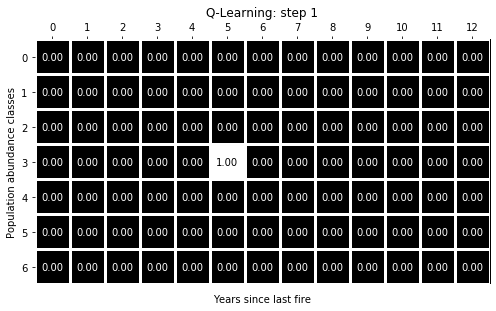

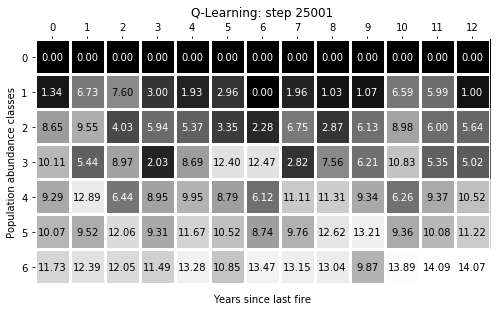

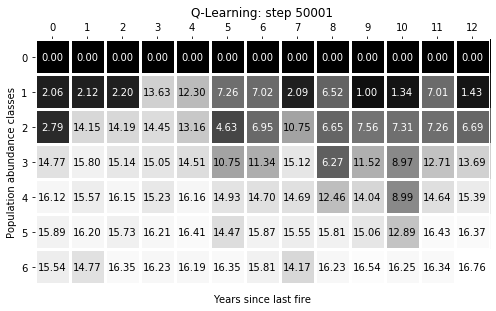

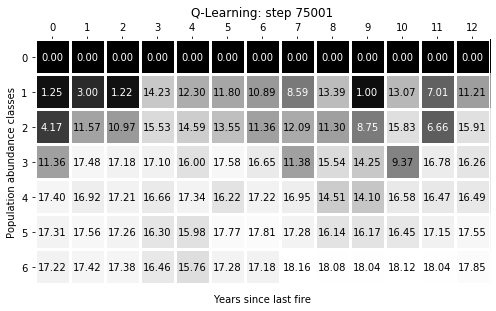

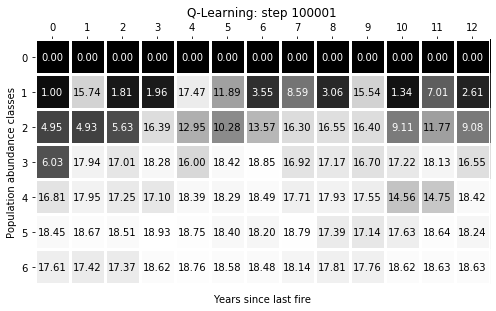

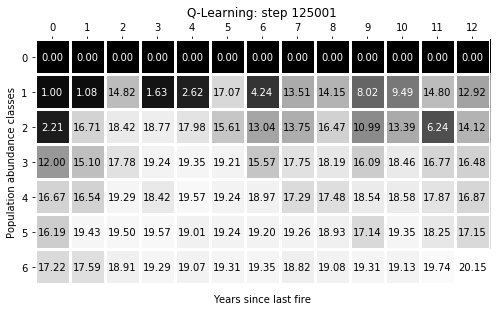

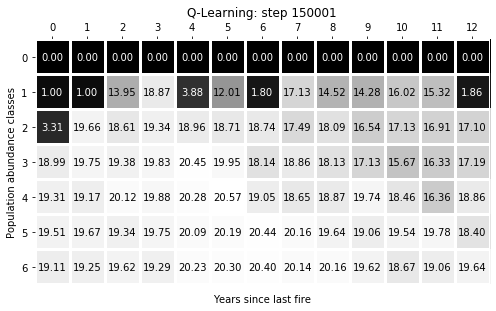

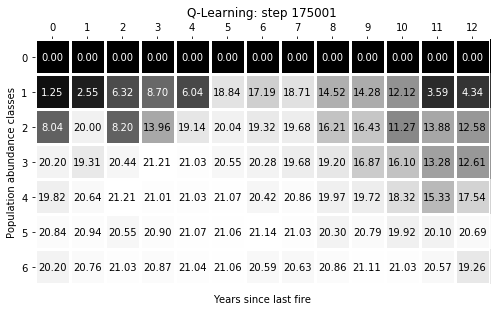

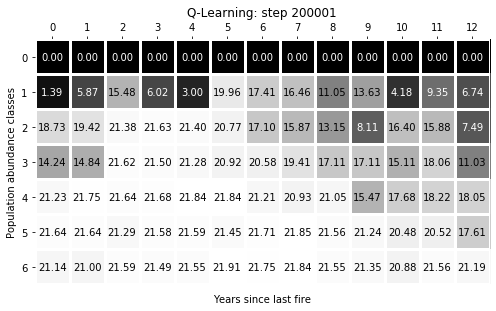

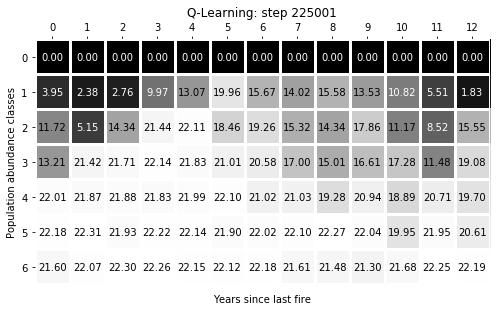

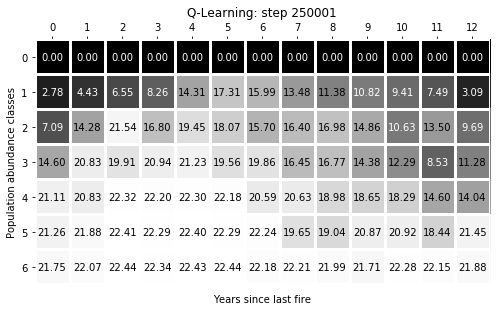

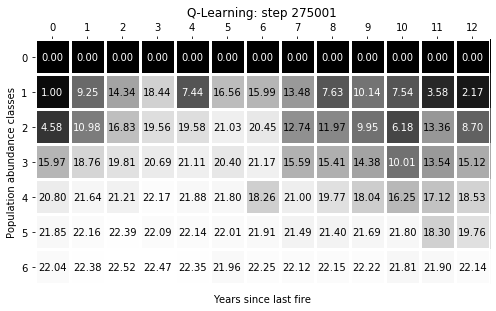

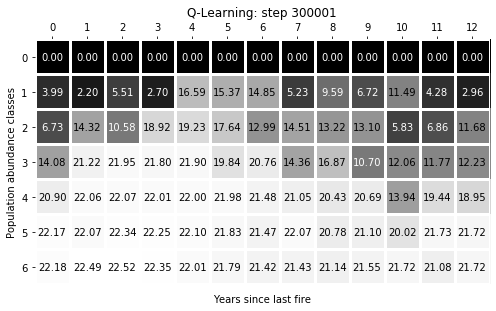

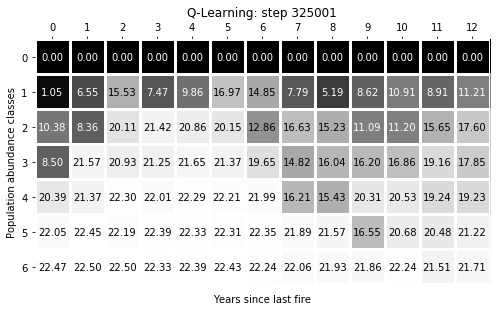

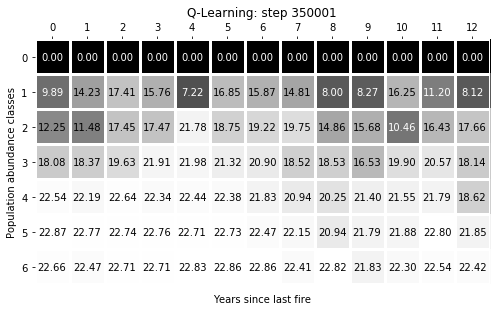

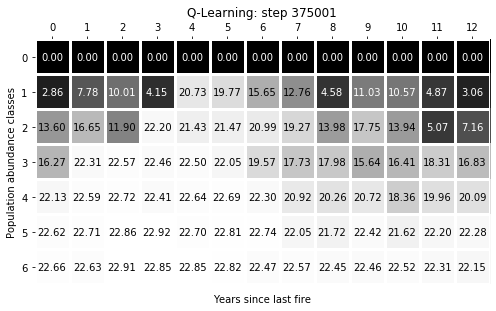

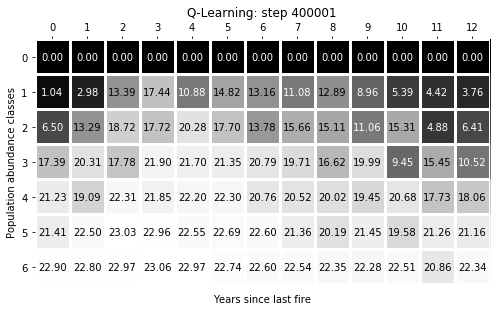

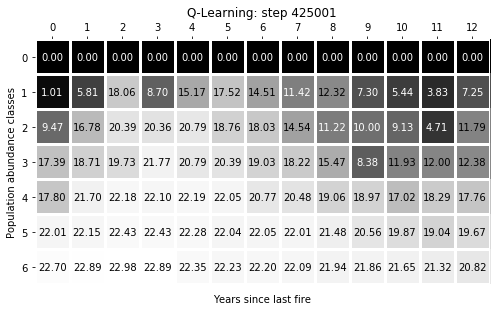

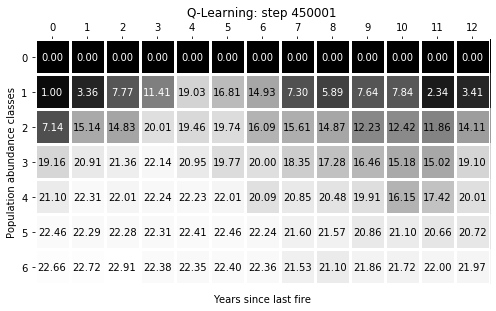

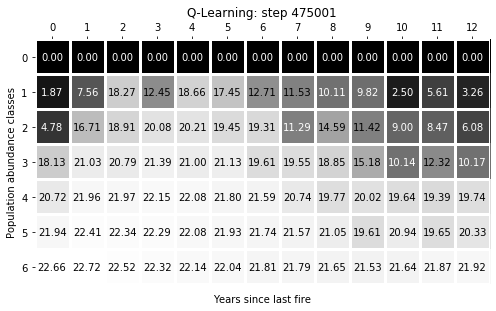

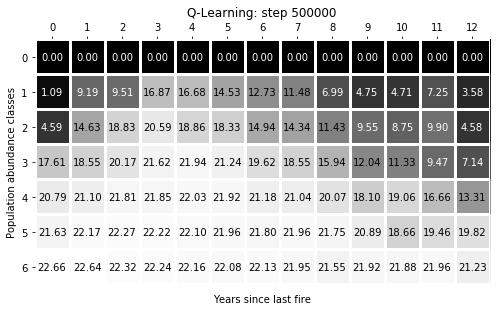

In [40]:
plot_heatmap(value_list_ql, policy_list_ql, increment=25000, title='Q-Learning', save_as='QL/Q-Learning')

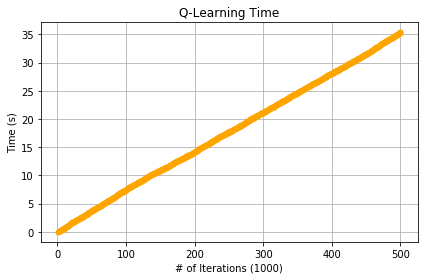

In [37]:
plot_times(times_list_ql[::1000], title='Q-Learning Time', xlabel='# of Iterations (1000)', save_as='QL/7x13_time')

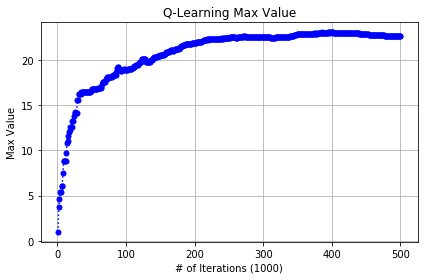

In [38]:
plot_max_values(max_values_list_ql[::1000], title='Q-Learning Max Value', xlabel='# of Iterations (1000)', save_as='QL/7x13_max_val')